# **Classifying newswires: A multiclass classification example**


In the previous section, you saw how to classify vector inputs into two mutually exclusive classes using a densely connected neural network. But what happens when you have more than two classes? In this section, you’ll build a network to classify Reuters newswires into 46 mutually exclusive topics. Because you have many classes, this problem is an instance of multiclass classification; and because each data point should be classified into only one category, the problem is more specifically an instance of single-label, multiclass classification. If each data point could belong to multiple categories (in this case, topics), you’d be facing a multilabel, multiclass classification problem.

## **Reuters newswires**

You’ll work with the Reuters dataset, a set of short newswires and their topics, published
by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There
are 46 different topics; some topics are more represented than others, but each topic
has at least 10 examples in the training set.
Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let’s
take a look.

### Loading Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

### Loading the Reuters dataset

In [ ]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


As with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.
You have 8,982 training examples and 2,246 test examples:

In [ ]:
display(len(train_data))
display(len(train_labels))

8982

8982

In [ ]:
display(len(test_data))
display(len(test_labels))

2246

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [ ]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here’s how you can decode it back to words.

### Decoding newswires back to text

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown

In [ ]:
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


The label associated with an example is an integer between 0 and 45—a topic index:

In [ ]:
train_data[10]

In [ ]:
train_labels[10]

3

### Preparing the data

 ### Encoding the data

In [ ]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
train_data

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110,

### Change label with one-hot-encode

To vectorize the labels, there are two possibilities: you can cast the label list as an integer
tensor, or you can use one-hot encoding. One-hot encoding is a widely used format
for categorical data, also called categorical encoding. In this case, one-hot encoding of
the labels consists of embedding each label as an all-zero vector with a 1 in the place of
the label index. Here’s an example:

In [ ]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels) # Vectorized training labels
one_hot_test_labels = to_one_hot(test_labels)  # Vectorized testing labels

But there is a built-in way to do this in Keras, which you’ve already seen in action
in the MNIST example

In [ ]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### Building your network

This topic-classification problem looks similar to the previous movie-review classification
problem: in both cases, you’re trying to classify short snippets of text. But there is
a new constraint here: the number of output classes has gone from 2 to 46. The
dimensionality of the output space is much larger.
In a stack of Dense layers like that you’ve been using, each layer can only access information
present in the output of the previous layer. 

In a stack of Dense layers like that you’ve been using, each layer can only access information
present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later
layers: each layer can potentially become an information bottleneck. 

In the previous
example, you used 16-dimensional intermediate layers, but a 16-dimensional space may
be too limited to learn to separate 46 different classes: such small layers may act as information
bottlenecks, permanently dropping relevant information.
For this reason you’ll use larger layers. 

Let’s go with 64 units.

### Model Definition

In [ ]:

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

There are two other things you should note about this architecture:

1. You end the network with a Dense layer of size 46. This means for each input
sample, the network will output a 46-dimensional vector. Each entry in this vector
(each dimension) will encode a different output class.

2. The last layer uses a softmax activation. You saw this pattern in the MNIST
example. It means the network will output a probability distribution over the 46
different output classes—for every input sample, the network will produce a 46-
dimensional output vector, where output[i] is the probability that the sample
belongs to class i. The 46 scores will sum to 1.
The best loss function to use in this case is categorical_crossentropy. It measures
the distance between two probability distributions: here, between the probability distribution
output by the network and the true distribution of the labels. By minimizing
the distance between these two distributions, you train the network to output something
as close as possible to the true labels.

### Compiling the model

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Validating your approach
Let’s set apart 1,000 samples in the training data to use as a validation set

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### Training the model
Now, let’s train the network for 20 epochs.

In [ ]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 74ms/step - loss: 3.8186 - accuracy: 0.0828 - val_loss: 3.7979 - val_accuracy: 0.0590
Epoch 2/20
16/16 [==============================] - 1s 46ms/step - loss: 3.7928 - accuracy: 0.0788 - val_loss: 3.7770 - val_accuracy: 0.0590
Epoch 3/20
16/16 [==============================] - 1s 47ms/step - loss: 3.7723 - accuracy: 0.1621 - val_loss: 3.7570 - val_accuracy: 0.0590
Epoch 4/20
16/16 [==============================] - 1s 46ms/step - loss: 3.7522 - accuracy: 0.1318 - val_loss: 3.7372 - val_accuracy: 0.3530
Epoch 5/20
16/16 [==============================] - 1s 47ms/step - loss: 3.7322 - accuracy: 0.3480 - val_loss: 3.7177 - val_accuracy: 0.3530
Epoch 6/20
16/16 [==============================] - 1s 47ms/step - loss: 3.7138 - accuracy: 0.3537 - val_loss: 3.6983 - val_accuracy: 0.3530
Epoch 7/20
16/16 [==============================] - 1s 46ms/step - loss: 3.6920 - accuracy: 0.3510 - val_loss: 3.6791 - val_accuracy: 0.3530
Epoch 8/20
16

In [ ]:
history

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plotting the training and validation loss

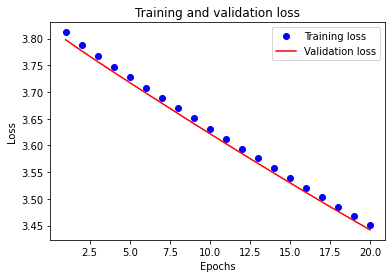

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting the training and validation accuracy

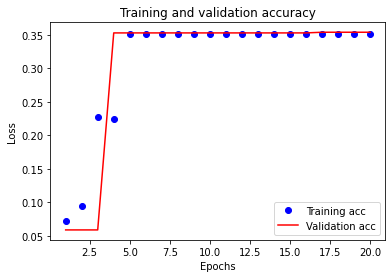

In [ ]:
plt.clf() # clears the figure
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The network begins to overfit after nine epochs. Let’s train a new network from
scratch for nine epochs and then evaluate it on the test set.

### Retraining a model from scratch

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=9,
batch_size=512,
validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 59ms/step - loss: 3.8185 - accuracy: 0.1242 - val_loss: 3.7980 - val_accuracy: 0.0440
Epoch 2/9
16/16 [==============================] - 1s 47ms/step - loss: 3.7926 - accuracy: 0.1139 - val_loss: 3.7771 - val_accuracy: 0.3530
Epoch 3/9
16/16 [==============================] - 1s 49ms/step - loss: 3.7715 - accuracy: 0.3555 - val_loss: 3.7571 - val_accuracy: 0.3530
Epoch 4/9
16/16 [==============================] - 1s 48ms/step - loss: 3.7520 - accuracy: 0.3511 - val_loss: 3.7373 - val_accuracy: 0.3530
Epoch 5/9
16/16 [==============================] - 1s 48ms/step - loss: 3.7322 - accuracy: 0.3478 - val_loss: 3.7177 - val_accuracy: 0.3530
Epoch 6/9
16/16 [==============================] - 1s 48ms/step - loss: 3.7121 - accuracy: 0.3560 - val_loss: 3.6984 - val_accuracy: 0.3530
Epoch 7/9
16/16 [==============================] - 1s 47ms/step - loss: 3.6951 - accuracy: 0.3519 - val_loss: 3.6790 - val_accuracy: 0.3530
Epoch 8/9
16/16 [===

In [ ]:
results

[3.64326548576355, 0.3615316152572632]

This approach reaches an accuracy of ~80%. With a balanced binary classification
problem, the accuracy reached by a purely random classifier would be 50%. But in
this case it’s closer to 19%, so the results seem pretty good, at least when compared to
a random baseline:



```
>>> import copy
>>> test_labels_copy = copy.copy(test_labels)
>>> np.random.shuffle(test_labels_copy)
>>> hits_array = np.array(test_labels) == np.array(test_labels_copy)
>>> float(np.sum(hits_array)) / len(test_labels)
0.18655387355298308
```



### Generating predictions on new data

You can verify that the predict method of the model instance returns a probability
distribution over all 46 topics. Let’s generate topic predictions for all of the test data

#### Generating predictions for new data

In [ ]:
predictions = model.predict(x_test)
predictions

array([[0.02348575, 0.02698697, 0.02099276, ..., 0.02173574, 0.02330261,
        0.01788807],
       [0.02067538, 0.02761782, 0.02069566, ..., 0.02059569, 0.020576  ,
        0.02057744],
       [0.02067538, 0.02761782, 0.02069566, ..., 0.02059569, 0.020576  ,
        0.02057744],
       ...,
       [0.02067538, 0.02761782, 0.02069566, ..., 0.02059569, 0.020576  ,
        0.02057744],
       [0.02067538, 0.02761782, 0.02069566, ..., 0.02059569, 0.020576  ,
        0.02057744],
       [0.02067538, 0.02761782, 0.02069566, ..., 0.02059569, 0.020576  ,
        0.02057744]], dtype=float32)

Each entry in predictions is a vector of length 46:

In [ ]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [ ]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class—the class with the highest probability:

In [ ]:
np.argmax(predictions[0])

16

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as
an integer tensor, like this:

```
y_train = np.array(train_labels)
y_test = np.array(test_labels)
```

The only thing this approach would change is the choice of the loss function. The loss
function categorical_crossentropy, expects the labels to follow
a categorical encoding. With integer labels, you should use sparse_categorical_
crossentropy:

```
model.compile(optimizer='rmsprop',
loss='sparse_categorical_crossentropy',
metrics=['acc'])
```



This new loss function is still mathematically the same as categorical_crossentropy;
it just has a different interface.

## The importance of having sufficiently large intermediate layers
We mentioned earlier that because the final outputs are 46-dimensional, you should
avoid intermediate layers with many fewer than 46 hidden units. Now let’s see what
happens when you introduce an information bottleneck by having intermediate layers
that are significantly less than 46-dimensional: for example, 4-dimensional.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 23ms/step - loss: 3.8015 - accuracy: 0.2571 - val_loss: 3.7416 - val_accuracy: 0.3540
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 3.7231 - accuracy: 0.3421 - val_loss: 3.6680 - val_accuracy: 0.3540
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 3.6481 - accuracy: 0.3539 - val_loss: 3.5963 - val_accuracy: 0.3540
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 3.5798 - accuracy: 0.3491 - val_loss: 3.5267 - val_accuracy: 0.3540
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 3.5106 - accuracy: 0.3571 - val_loss: 3.4593 - val_accuracy: 0.3540
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 3.4431 - accuracy: 0.3585 - val_loss: 3.3940 - val_accuracy: 0.3540
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 3.3801 - accuracy: 0.3539 - val_loss: 3.3307 - val_accuracy: 0.3540
Epoch 8/20
63

The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough
information to recover the separation hyperplanes of 46 classes) into an intermediate
space that is too low-dimensional. The network is able to cram most of the necessary
information into these eight-dimensional representations, but not all of it.

## Further experiments
1. Try using larger or smaller layers: 32 units, 128 units, and so on.

2. You used two hidden layers. Now try using a single hidden layer, or three hidden
layers.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 21ms/step - loss: 3.8016 - accuracy: 0.1776 - val_loss: 3.7418 - val_accuracy: 0.2220
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 3.7240 - accuracy: 0.2236 - val_loss: 3.6679 - val_accuracy: 0.2220
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 3.6501 - accuracy: 0.2882 - val_loss: 3.5964 - val_accuracy: 0.3530
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 3.5783 - accuracy: 0.3564 - val_loss: 3.5270 - val_accuracy: 0.3540
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 3.5109 - accuracy: 0.3449 - val_loss: 3.4592 - val_accuracy: 0.3540
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 3.4375 - accuracy: 0.3502 - val_loss: 3.3941 - val_accuracy: 0.3540
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 3.3768 - accuracy: 0.3576 - val_loss: 3.3307 - val_accuracy: 0.3540
Epoch 8/20
63

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 3.8015 - accuracy: 0.1899 - val_loss: 3.7416 - val_accuracy: 0.2220
Epoch 2/20
63/63 [==============================] - 1s 18ms/step - loss: 3.7224 - accuracy: 0.2719 - val_loss: 3.6679 - val_accuracy: 0.2220
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 3.6508 - accuracy: 0.2582 - val_loss: 3.5961 - val_accuracy: 0.2230
Epoch 4/20
63/63 [==============================] - 1s 19ms/step - loss: 3.5776 - accuracy: 0.2939 - val_loss: 3.5263 - val_accuracy: 0.3540
Epoch 5/20
63/63 [==============================] - 1s 19ms/step - loss: 3.5114 - accuracy: 0.3519 - val_loss: 3.4588 - val_accuracy: 0.3540
Epoch 6/20
63/63 [==============================] - 1s 18ms/step - loss: 3.4411 - accuracy: 0.3569 - val_loss: 3.3935 - val_accuracy: 0.3540
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 3.3769 - accuracy: 0.3523 - val_loss: 3.3305 - val_accuracy: 0.3540
Epoch 8/20
63

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])
model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=128,
validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 21ms/step - loss: 3.8016 - accuracy: 0.2249 - val_loss: 3.7421 - val_accuracy: 0.2220
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 3.7224 - accuracy: 0.3302 - val_loss: 3.6684 - val_accuracy: 0.3530
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 3.6500 - accuracy: 0.3523 - val_loss: 3.5966 - val_accuracy: 0.3530
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 3.5788 - accuracy: 0.3624 - val_loss: 3.5270 - val_accuracy: 0.3530
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 3.5107 - accuracy: 0.3506 - val_loss: 3.4595 - val_accuracy: 0.3530
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 3.4461 - accuracy: 0.3517 - val_loss: 3.3940 - val_accuracy: 0.3530
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 3.3791 - accuracy: 0.3479 - val_loss: 3.3310 - val_accuracy: 0.3530
Epoch 8/20
63

## Wrapping up

If you’re trying to classify data points among N classes, your network should end
with a Dense layer of size N. In a single-label, multiclass classification problem, your network should end
with a softmax activation so that it will output a probability distribution over the
N output classes.

1.Categorical crossentropy is almost always the loss function you should use for
such problems. It minimizes the distance between the probability distributions
output by the network and the true distribution of the targets.

2.There are two ways to handle labels in multiclass classification:


*   Encoding the labels via categorical encoding (also known as one-hot encoding and using categorical_crossentropy as a loss function
*   Encoding the labels as integers and using the sparse_categorical_crossentropy
loss function

3.If you need to classify data into a large number of categories, you should avoid
creating information bottlenecks in your network due to intermediate layers
that are too small.